In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization,Cropping2D
from tensorflow.keras.models import Model
import random
import tensorflow as tf
from tensorflow.keras import backend as K

In [11]:
# Đọc tệp Excel vào DataFrame
file_path = "/kaggle/input/daaset/data/classification.xlsx"  # Đường dẫn đến file Excel
df = pd.read_excel(file_path)

# Đường dẫn thư mục ảnh và mask
image_path = '/kaggle/input/daaset/data/images'
mask_path = '/kaggle/input/daaset/data/masks'
print("a1")

a1


In [12]:
from sklearn.model_selection import train_test_split

# Lọc những ảnh có mask
df_with_mask = df[df['mask_flag'] == 1].copy()

# Chia Train (70%) và temp (30%)
df_train, df_temp = train_test_split(df_with_mask, test_size=0.3, random_state=42, shuffle=True)

# Chia temp thành Validation (15%) và Test (15%)
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, shuffle=True)

# Kiểm tra số lượng
print("Train:", len(df_train), "Validation:", len(df_valid), "Test:", len(df_test))


Train: 1306 Validation: 280 Test: 281


In [13]:
# Tạo cột đường dẫn
df_train['image_path'] = df_train['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_train['mask_path']  = df_train['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_test['image_path'] = df_test['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_test['mask_path']  = df_test['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_valid['image_path'] = df_valid['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_valid['mask_path']  = df_valid['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

print("a1")

a1


In [14]:
import tensorflow as tf
import random

# Hàm load ảnh và mask (bỏ comment, dùng bình thường)
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [224, 224], method='nearest')
    mask = tf.cast(mask > 0, tf.uint8)  # <- Rất quan trọng: đưa mọi giá trị khác 0 về 1
    mask = tf.squeeze(mask, axis=-1)
    mask = tf.one_hot(mask, depth=2)

    return image, mask

    
def random_augment(image, mask):
    # Lật ngang
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Dịch chuyển
    if tf.random.uniform(()) > 0.5:
        shift = tf.random.uniform(shape=[2], minval=-10, maxval=10, dtype=tf.int32)
        image = tf.roll(image, shift=shift, axis=[0, 1])
        mask = tf.roll(mask, shift=shift, axis=[0, 1])

    return image, mask

# Hàm load với augment cho train dataset
def load_image_and_mask_with_aug(image_path, mask_path):
    image, mask = load_image_and_mask(image_path, mask_path)

    # Gọi augment bên ngoài
    image, mask = random_augment(image, mask)

    # Có thể thêm augment riêng cho ảnh ở đây
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, 0.1)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_contrast(image, 0.8, 1.2)

    return image, mask


# Chọn batch size cố định hoặc random
BATCH_SIZE = 8  # hoặc random.choice([8]) nếu muốn random

# Tạo dataset train có augment, chỉ khi df_train không rỗng
if not df_train.empty:
    train_dataset = tf.data.Dataset.from_tensor_slices((df_train['image_path'], df_train['mask_path']))
    train_dataset = train_dataset.map(load_image_and_mask_with_aug, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
else:
    print("⚠️ df_train is empty. Skipping train_dataset creation.")
    train_dataset = None

# Dataset validation (không augment)
if not df_valid.empty:
    val_dataset = tf.data.Dataset.from_tensor_slices((df_valid['image_path'], df_valid['mask_path']))
    val_dataset = val_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
else:
    print("⚠️ df_valid is empty. Skipping val_dataset creation.")
    val_dataset = None

# Dataset test (không augment)
if not df_test.empty:
    test_dataset = tf.data.Dataset.from_tensor_slices((df_test['image_path'], df_test['mask_path']))
    test_dataset = test_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
else:
    print("⚠️ df_test is empty. Skipping test_dataset creation.")
    test_dataset = None

print("Datasets prepared.")


Datasets prepared.


Train batch shape:
Image batch shape: (8, 224, 224, 1)
Mask batch shape: (8, 224, 224, 2)


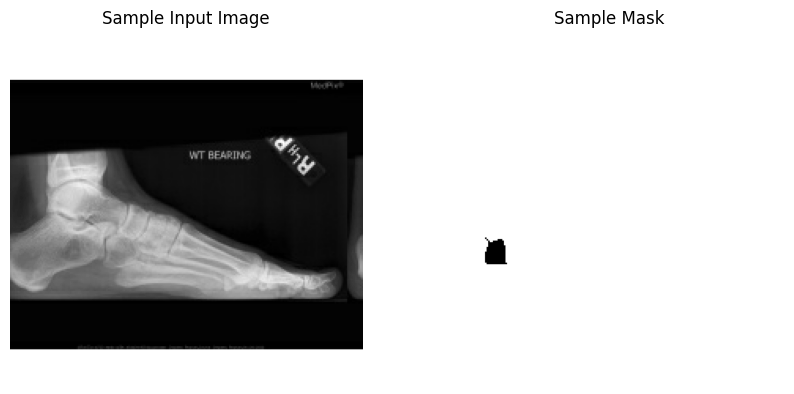

Validation batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 2)


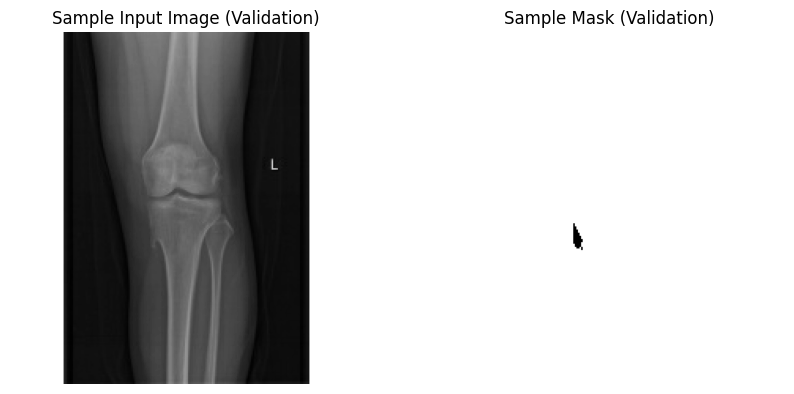

Test batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 2)


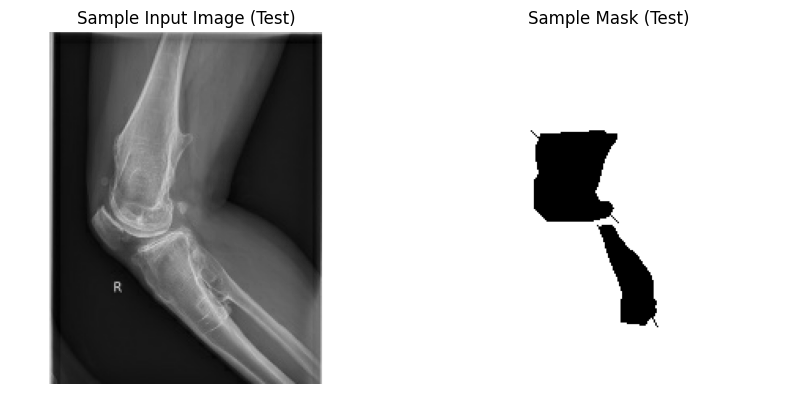

a1


In [15]:
import matplotlib.pyplot as plt

# Kiểm tra một batch từ train_dataset
for images, masks in train_dataset.take(1):  # Lấy 1 batch từ train_dataset
    print("Train batch shape:")
    print("Image batch shape:", images.shape)  # Kích thước của batch ảnh
    print("Mask batch shape:", masks.shape)    # Kích thước của batch mask

    # Hiển thị một ảnh và mask
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')  # Hiển thị ảnh đầu tiên trong batch (1 channel)
    plt.title("Sample Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')  # Hiển thị mask đầu tiên trong batch (1 channel)
    plt.title("Sample Mask")
    plt.axis('off')

    plt.show()
    break  # Dừng sau khi đã kiểm tra 1 batch

# Kiểm tra một batch từ val_dataset
for images, masks in val_dataset.take(1):
    print("Validation batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Validation)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Validation)")
    plt.axis('off')

    plt.show()
    break

# Kiểm tra một batch từ test_dataset
for images, masks in test_dataset.take(1):
    print("Test batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Test)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Test)")
    plt.axis('off')

    plt.show()
    break
print("a1")

In [16]:
from tensorflow.keras.layers import Dropout
def segnet(input_shape=(224, 224, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 112x112

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 56x56

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 28x28

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 14x14

    # Decoder
    x = UpSampling2D((2, 2))(x)  # 28x28
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)  # 56x56
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)  # 112x112
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)  # 224x224
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Gọi model
model = segnet(input_shape=(224, 224, 1), num_classes=2)

def weighted_dice_loss(y_true, y_pred, class_weights=[0.2, 0.8]):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    dice = 0
    for i in range(len(class_weights)):
        y_true_f = K.flatten(y_true[..., i])
        y_pred_f = K.flatten(y_pred[..., i])
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f) + K.sum(y_pred_f)
        dice_score = (2. * intersection + smooth) / (union + smooth)
        dice += class_weights[i] * (1 - dice_score)  # Weighted Dice Loss

    return dice
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)


model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss=weighted_dice_loss,  # use the new weighted loss
    metrics=[
        dice_coef,
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)



In [17]:
# Đếm số pixel mỗi lớp trong mỗi tập (sau one-hot)
def count_class_pixels(dataset):
    class_counts = [0, 0]
    for _, mask in dataset.take(50):  # kiểm tra một vài batch
        summed = tf.reduce_sum(mask, axis=[0, 1, 2])
        class_counts[0] += summed[0].numpy()
        class_counts[1] += summed[1].numpy()
    return class_counts

print("Train class distribution:", count_class_pixels(train_dataset))
print("Val class distribution:", count_class_pixels(val_dataset))
print("Test class distribution:", count_class_pixels(test_dataset))


Train class distribution: [19671609.0, 398791.0]
Val class distribution: [13814631.0, 234649.0]
Test class distribution: [13818453.0, 281003.0]


In [18]:

epochs = 210

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)

print("✅ Quá trình huấn luyện hoàn tất!")


Epoch 1/210
164/164 ━━━━━━━━━━━━━━━━━━━━ 77s 237ms/step - dice_coef: 0.7621 - loss: 0.7459 - mean_io_u_1: 0.2381 - precision_1: 0.7621 - recall_1: 0.7621 - val_dice_coef: 0.9835 - val_loss: 0.7974 - val_mean_io_u_1: 0.2500 - val_precision_1: 0.9833 - val_recall_1: 0.9833
Epoch 2/210
164/164 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - dice_coef: 0.8874 - loss: 0.6850 - mean_io_u_1: 0.2324 - precision_1: 0.8874 - recall_1: 0.8874 - val_dice_coef: 0.9835 - val_loss: 0.8006 - val_mean_io_u_1: 0.2500 - val_precision_1: 0.9833 - val_recall_1: 0.9833
Epoch 3/210
164/164 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - dice_coef: 0.9003 - loss: 0.6695 - mean_io_u_1: 0.2378 - precision_1: 0.9003 - recall_1: 0.9003 - val_dice_coef: 0.7680 - val_loss: 0.7408 - val_mean_io_u_1: 0.2014 - val_precision_1: 0.7661 - val_recall_1: 0.7661
Epoch 4/210
164/164 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - dice_coef: 0.9276 - loss: 0.6390 - mean_io_u_1: 0.2408 - precision_1: 0.9277 - recall_1: 0.9277 - val_dice_coef: 0.8163 - val_

In [22]:
results = model.evaluate(test_dataset)
print(f"Results: {results}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - dice_coef: 0.9860 - loss: 0.2937 - mean_io_u_1: 0.6870 - precision_1: 0.9860 - recall_1: 0.9860
Results: [0.2996116578578949, 0.9878767728805542, 0.6861683130264282, 0.9877434372901917, 0.9877434372901917]


In [25]:
model.save('n1.h5')
model.save('/kaggle/working//n1.h5') 

In [26]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def print_dice_score(y_true, y_pred):
    score = dice_score(y_true, y_pred)
    print("Dice Score:", float(score.numpy()))

# Ví dụ chạy thử:
y_true = tf.constant([[0, 1, 1], [0, 1, 0]], dtype=tf.float32)
y_pred = tf.constant([[0, 1, 0], [0, 1, 1]], dtype=tf.float32)

print_dice_score(y_true, y_pred)


Dice Score: 0.6666667461395264
